# Atmospheric Composition and Structure

Supplement to Chapter 1 of [_A First Course in Atmospheric Thermodynamics_ by Grant W. Petty, Sundog Publishing, 2008](https://sundogpublishingstore.myshopify.com/products/a-first-course-in-atmospheric-thermodynamics-g-w-petty)

## Figure 1.4: CO$_2$ concentration measured at Mauna Loa (updated with recent data)
Also known as the "Keeling Curve"
![CO2 timeseries](https://scripps.ucsd.edu/bluemoon/co2_400/mlo_full_record.png)

Source: https://keelingcurve.ucsd.edu ([CC BY license](https://creativecommons.org/licenses/by/4.0/))



## Figure 1.5: An observed temperature profile

You can browse upper-air observations archived at the University of Wyoming at this site: <http://weather.uwyo.edu/upperair/sounding.html>

Below we are going to access the same data in a Python script. As you can see below, we regenerate the temperature plot in Figure 1.5 by querying the data base for the correct station, date, and time.

We will probably dive deeper into how some of this code works later. For now, the important point is that we can easily access and plot radiosonde observations for arbitrary stations and dates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from metpy.units import units
from metpy.plots import SkewT
from siphon.simplewebservice.wyoming import WyomingUpperAir

In [2]:
date = datetime(year=2004, month=9, day=8, hour=12) # year, month, day, hour (12Z)
station = 'DDC'  # station code for Dodge City, Kansas
df = WyomingUpperAir.request_data(date, station)

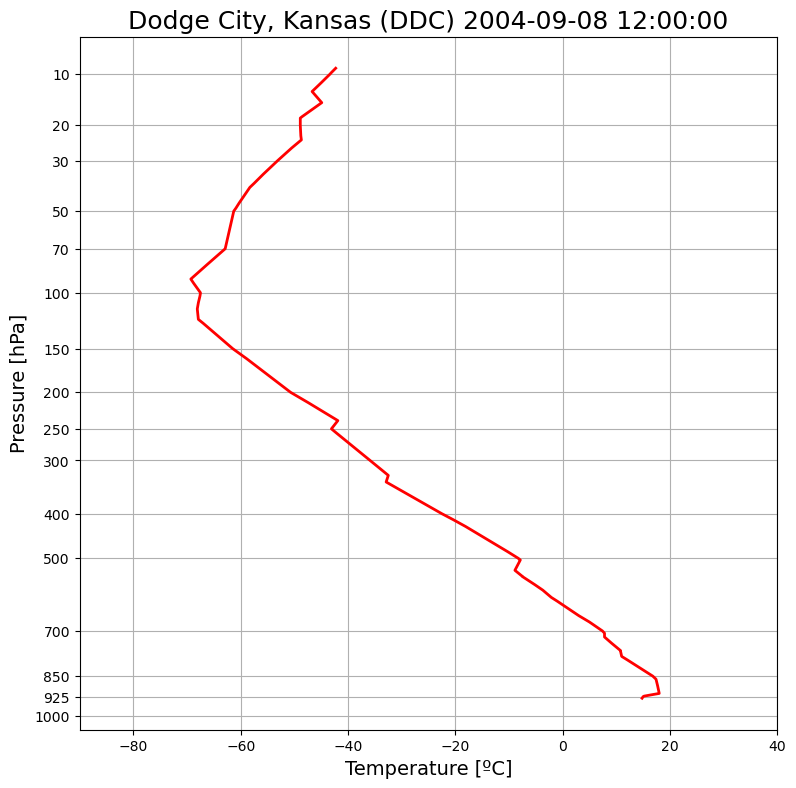

In [3]:
# Figure 1.5 is plotted as a "Stüve diagram" 
# meaning the y axis is proportional to p^0.286
pticks = np.array([10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000])
k = 0.286

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(df['temperature'], df['pressure']**k, 'r', linewidth=2)
ax.invert_yaxis()
ax.set_xlim(-90,40)
ax.set_yticks(pticks**k)
ax.set_yticklabels(pticks)
ax.set_ylabel('Pressure [hPa]', fontsize=14)
ax.set_xlabel('Temperature [ºC]', fontsize=14)
ax.grid()
ax.set_title(f'Dodge City, Kansas ({station}) {date}', fontsize=18);

Compare against Figure 1.5 in the text. It's exactly the same data, and plotted the same way!

Here we are plotting temperature on the $x$ axis, and pressure decreasing upward on the $y$ axis, with the intervals between pressure levels getting larger as we go up. As you can see in the code above, the $y$ axis is actual $p^{0.286}$. This plotting convention is known as a _Stüve diagram_.

We will use similar code to access radiosonde data many times during this course, but we will make some changes to how we plot the results.

## Figure 1.7: The US Standard Atmosphere

We'll talk more about the definition, meaning, and use of the so-called "Standard Atmosphere" later in the course.

The code below is not so pretty, but it does reproduce a version of Figure 1.7.

Text(0, 0.5, 'Pressure [hPa]')

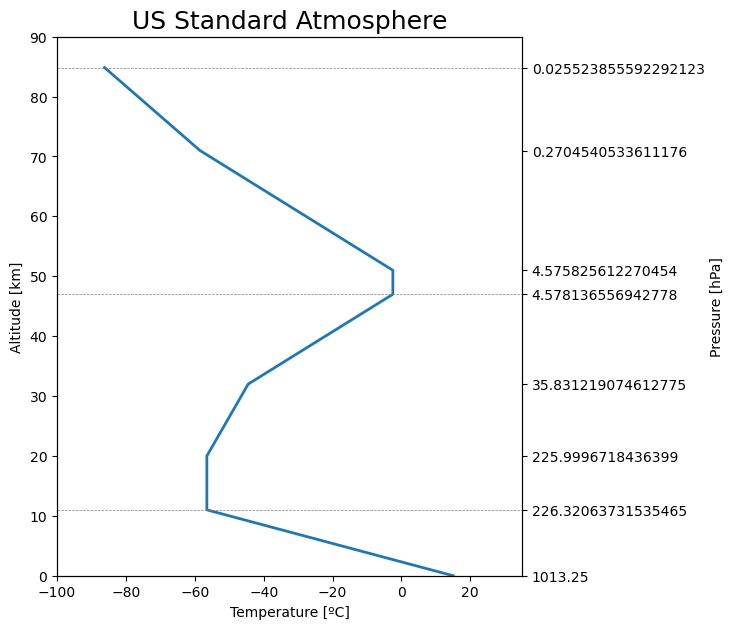

In [4]:
layer_boundaries = np.array([0., 11., 20., 32., 47., 51., 
                             71., 84.852])
lapse_rate = np.array([6.5, 0., -1., -2.8, 0., 2.8, 2])
num_layers = len(lapse_rate)
temperature_boundaries = np.zeros_like(layer_boundaries)
temperature_boundaries[0] = 288.15
pressure_boundaries = np.zeros_like(layer_boundaries)
pressure_boundaries[0] = 1013.25
Rd = 287.05307
g = 9.80665
layer_top = layer_boundaries[1:]
layer_bottom = layer_boundaries[:-1]

def T_from_lapse(height_above_base, lapse, base_temp=288.15):
    return base_temp - lapse*height_above_base

for n in range(num_layers):
    temperature_boundaries[n+1] = T_from_lapse(layer_top[n]-layer_bottom[n], 
                            lapse_rate[n],
                            base_temp=temperature_boundaries[n])

temperature_bottom = temperature_boundaries[:-1]
temperature_top = temperature_boundaries[1:]

for n in range(num_layers):
    temp_ratio = temperature_boundaries[n+1]/temperature_boundaries[n]
    if lapse_rate[n] != 0:
        pressure_boundaries[n+1] = (pressure_boundaries[n]*(temp_ratio)**(g/Rd/lapse_rate[n]*1000.))
    else:
        pressure_boundaries[n+1] = (pressure_boundaries[n]*
                    np.exp(g/Rd/temperature_boundaries[n]*
                           (layer_boundaries[n]-layer_boundaries[n+1])))

pressure_bottom = pressure_boundaries[:-1]
pressure_top = pressure_boundaries[1:]

temp_min = -100; temp_max = 35;

fig, ax = plt.subplots(figsize=(6,7))
ax.plot(temperature_boundaries - 273.15, layer_boundaries, linewidth=2)
ax.set_ylabel('Altitude [km]')
ax.set_xlabel('Temperature [ºC]')
ax.set_title('US Standard Atmosphere', fontsize=18)
for n in [0,3,6]:
    ax.hlines(layer_top[n], temp_min, temp_max, linewidth=0.5, color='grey', linestyle='--')
ax.set_xbound([temp_min, temp_max])
ax.set_ylim(0,90)
ax2 = ax.twinx()
ax2.set_ylim(0,90)
ax2.set_yticks(layer_boundaries, labels=pressure_boundaries)
ax2.set_ylabel('Pressure [hPa]')

## Figure 1.8: Summer versus Winter Temperature Profiles

Here we recreate Figure 1.8 by accessing the radiosonde data for the same summer and winter dates as used in the book. The data are plotted on the same Stüve diagram as in Figure 1.5.

In [5]:
summer = datetime(year=2004, month=7, day=4, hour=0) 
winter = datetime(year=2004, month=1, day=27, hour=12)
summer_data = WyomingUpperAir.request_data(summer, station)
winter_data = WyomingUpperAir.request_data(winter, station)

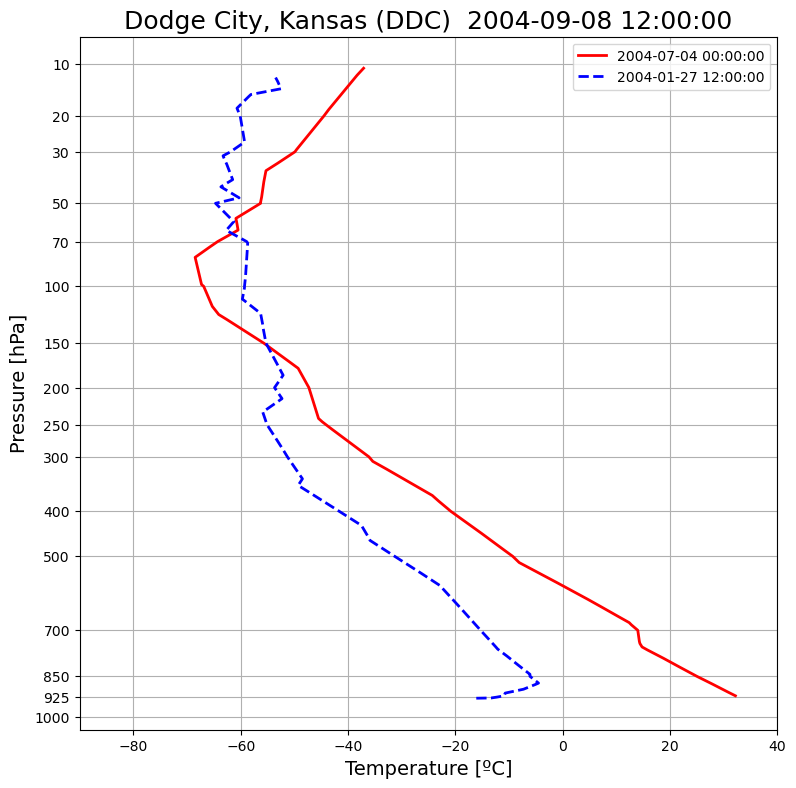

In [6]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(summer_data['temperature'], summer_data['pressure']**k, 
        'r', linewidth=2, label=f'{summer}')
ax.plot(winter_data['temperature'], winter_data['pressure']**k, 
        'b--', linewidth=2, label=f'{winter}')
ax.invert_yaxis()
ax.set_xlim(-90,40)
ax.set_yticks(pticks**k)
ax.set_yticklabels(pticks)
ax.set_ylabel('Pressure [hPa]', fontsize=14)
ax.set_xlabel('Temperature [ºC]', fontsize=14)
ax.grid()
ax.legend()
ax.set_title(f'Dodge City, Kansas ({station})  {date}', fontsize=18);

## Figure 1.9: Tropical versus Arctic profiles

Again, we use very similar code here to retrieve the sounding data for Bintulu and Resolute and plot them on the same Stüve diagram as before to reproduce Figure 1.9

In [7]:
tropical_time = datetime(year=2004, month=1, day=4, hour=0)
arctic_time = datetime(year=2004, month=1, day=24, hour=0)
tropical_station = 'WBGB'
arctic_station = 'YRB'
tropical_data = WyomingUpperAir.request_data(tropical_time, tropical_station)
arctic_data = WyomingUpperAir.request_data(arctic_time, arctic_station)

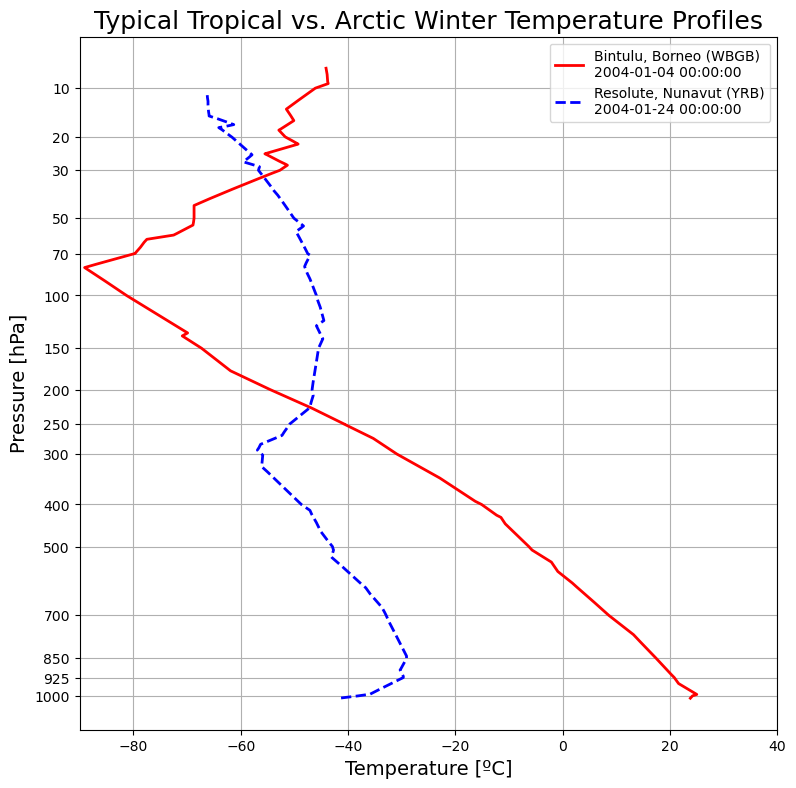

In [8]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(tropical_data['temperature'], tropical_data['pressure']**k, 
        'r', linewidth=2, label=f'Bintulu, Borneo ({tropical_station})\n{tropical_time}')
ax.plot(arctic_data['temperature'], arctic_data['pressure']**k, 
        'b--', linewidth=2, label=f'Resolute, Nunavut ({arctic_station})\n{arctic_time}')
ax.invert_yaxis()
ax.set_xlim(-90,40)
ax.set_yticks(pticks**k)
ax.set_yticklabels(pticks)
ax.set_ylabel('Pressure [hPa]', fontsize=14)
ax.set_xlabel('Temperature [ºC]', fontsize=14)
ax.grid()
ax.legend()
ax.set_title(f'Typical Tropical vs. Arctic Winter Temperature Profiles',
            fontsize=18);

## Figure 1.19: emagram versus skew-T plots

Figure 1.19 shows the same plotted two different ways. 

The _emagram_ is like a Stüve diagram, with temperature on the $x$ axis, except the pressure axis is stretched in a different way. Instead of $p^{0.286}$, we use the natural log $\ln p$ on the $y$ axis. As we will see later on, the log of pressure is approximately proportional to altitude in meters. 

The _Skew T log p_ diagram (almost always abbreviated to just _Skew-T_) uses the same log axis for pressure (again proportional to height), but rotates the isotherms (lines of constant air temperature) so they are diagonal. This can make it easier to visualize sounding data, since the temperature almost always decreases by quite a lot with height.

We will be plotting a lot of Skew-T diagrams in this course. Below, I use the extremely useful Python package [MetPy](https://unidata.github.io/MetPy/) to help plot the Skew-T plot with minimal code.

In [9]:
wisconsin_date = datetime(year=2005, month=8, day=25, hour=12)
wisconsin_station = 'GRB'
wisconsin_data = WyomingUpperAir.request_data(wisconsin_date, wisconsin_station)

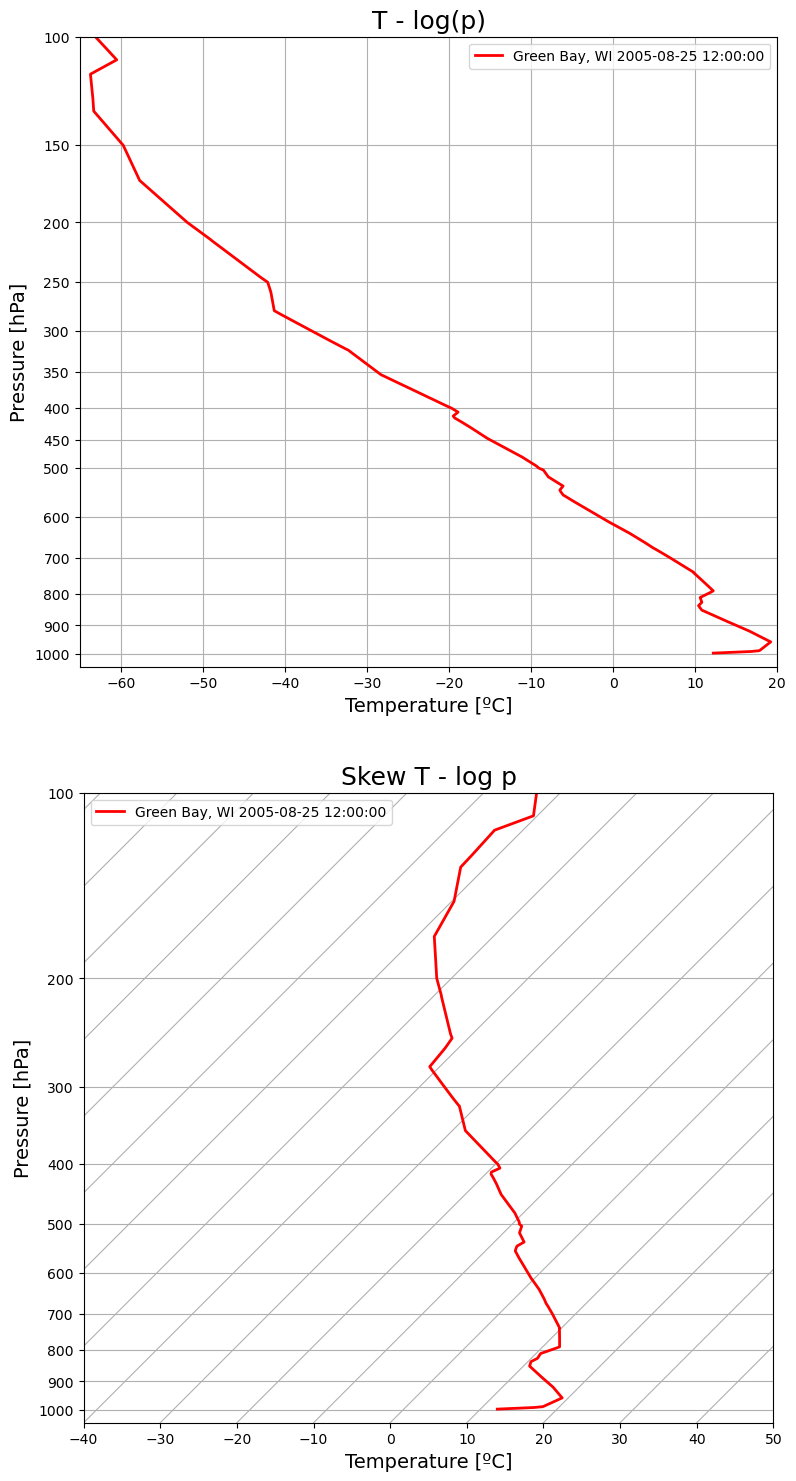

In [10]:
pticks = np.array([100,150,200,250,300,350,400,450,500,600,700,800,900,1000])

fig = plt.figure(figsize=(9,18))

ax = fig.add_subplot(2,1,1)
ax.plot(wisconsin_data['temperature'], 
        np.log(wisconsin_data['pressure']), 
        'r', linewidth=2, label=f'Green Bay, WI {wisconsin_date}')
ax.set_xlim(-65,20)
ax.set_title('T - log(p)', fontsize=18);
ax.invert_yaxis()
ax.set_ylim(np.log(1050), np.log(100))
ax.set_yticks(np.log(pticks))
ax.set_yticklabels(pticks)
ax.grid()

skew = SkewT(fig=fig, subplot=(2,1,2), rotation=45)
skew.plot(wisconsin_data['pressure'], wisconsin_data['temperature'], 
        'r', linewidth=2, label=f'Green Bay, WI {wisconsin_date}')
skew.ax.set_title('Skew T - log p', fontsize=18);

for axis in [ax, skew.ax]:
    axis.set_ylabel('Pressure [hPa]', fontsize=14)
    axis.set_xlabel('Temperature [ºC]', fontsize=14)
    axis.legend()